In [15]:
import pandas as pd
import numpy as np
from stop_words import get_stop_words
import re
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib.textpath import TextPath
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram
from sklearn import mixture
from collections import Counter

In [197]:
#vereinfachte Methode:
def linkage_matrix(n_samples, children, distances):
    """
    create a linkage matrix for the dendogram method in scipy
    n_samples: int, number of samples
    children: list of lists, clustered data points (should be 2)
    distances: list of distances between nodes
    """
    # Create linkage matrix
    

    # create the counts of samples under each node
    counts = np.zeros(children.shape[0])
    for i, merge in enumerate(children):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    return np.column_stack([children, distances, counts]).astype(float)

# Gibt eine Worthäufigkeitsliste zurück, nur den Namen des Genre in Form eines Strings als Argument
def wordlister(genre):
    stop_words = get_stop_words('de')
    stop_words.append('ch00ffff')
    # Alle Texte eines Genres konkatenieren
    film_genre = ""
    for film in df.iterrows():
        if film[1].genre == genre:
            film_genre = film_genre + film[1].text
    # Tokenisieren
    genre_tokens = re.findall("\w+", film_genre.lower())
    # Stopwordliste 
    tokens_without_stopwords =[]
    for word in genre_tokens:
        if word not in stop_words:
            tokens_without_stopwords.append(word)
    #Rückgabe mit gezählten Tokens
    return Counter(tokens_without_stopwords)



# Plottet die Wörterliste aus der oberen Funktion, mit .most_common() kann die Zahl begrenzt werden
def wordlistplot(wordlist):
    plt.figure(figsize=(15,8))
    for word in wordlist:
        x= word[0]
        y = word[1]
        plt.bar(x, y)
    plt.show()

In [4]:
df = pd.read_csv('../../dataset/movies_complete.csv')
df.shape

(3728, 56)

In [5]:
df.head()

,Unnamed: 0,filename,text,IMDB_ID,genre,year,production_region,corpus,duration,directors,...,Ratings,Metascore,imdbRating,imdbVotes,Type,DVD,BoxOffice,Production,Website,Response
0,0,6416324.xml,Der Roman von Alexandre Dumas dem Älteren hatt...,tt1104767,"Adventure,Drama,History",1943.0,French,untokenisiert,90.0,"nm0894509,nm0148602",...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,7.1,76,movie,NaN,NaN,NaN,NaN,True
1,1,4732286.xml,Hände hoch oder ich schieße ( 1966 ) dTV - MDR...,tt1631717,Comedy,1966.0,German,untokenisiert,75.0,nm0440757,...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.0,19,movie,NaN,NaN,NaN,NaN,True
2,2,6122081.xml,"Hallo , Manuela ? Störe ich ? Kann ich zu dir ...",tt1271979,Drama,1967.0,French,untokenisiert,78.0,nm0816215,...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.6,25,movie,NaN,NaN,NaN,NaN,True
3,3,5594522.xml,Dein Vater war ein ausgezeichneter Kämpfer . A...,tt3141954,"Action,Adventure",1978.0,Cantonese,untokenisiert,82.0,nm1172472,...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,5.8,23,movie,NaN,NaN,NaN,NaN,True
4,4,5618549.xml,"Na los , iss jetzt schnell auf . Junge , ist d...",tt1065116,Action,1979.0,Japanese,untokenisiert,96.0,nm0814232,...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,5.6,32,movie,NaN,NaN,NaN,NaN,True


In [185]:
genre_combination_frequs = Counter(df.genre)
genre_combination_frequs.most_common(90)

[('Drama', 403),
 ('Comedy', 203),
 ('Comedy,Drama', 144),
 ('Drama,Romance', 142),
 ('Comedy,Drama,Romance', 121),
 ('Horror', 94),
 ('Comedy,Romance', 87),
 ('Horror,Thriller', 79),
 ('Drama,Thriller', 77),
 ('Action,Crime,Drama', 71),
 ('Documentary', 70),
 ('Crime,Drama,Thriller', 65),
 ('Adventure,Animation,Comedy', 65),
 ('Action,Crime,Thriller', 54),
 ('Thriller', 53),
 ('Action,Adventure,Sci-Fi', 46),
 ('Action,Comedy,Crime', 43),
 ('Action,Adventure,Drama', 41),
 ('Action', 40),
 ('Crime,Drama', 38),
 ('Biography,Drama', 35),
 ('Biography,Drama,History', 33),
 ('Crime,Drama,Mystery', 33),
 ('Action,Thriller', 31),
 ('Horror,Mystery,Thriller', 30),
 ('Action,Adventure,Fantasy', 30),
 ('Comedy,Horror', 28),
 ('Action,Adventure,Comedy', 28),
 ('Comedy,Crime,Drama', 27),
 ('Action,Adventure,Animation', 22),
 ('Crime,Thriller', 22),
 ('Action,Horror,Sci-Fi', 22),
 ('Family', 22),
 ('Action,Drama,History', 21),
 ('Action,Comedy', 20),
 ('Action,Drama', 20),
 ('Action,Sci-Fi,Thriller

## Vorbereitung der Label und Slice auf die Genre

blue    71
red     70
Name: labelcolor, dtype: int64

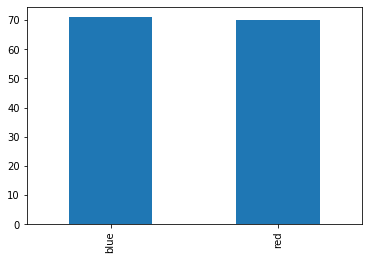

In [191]:
#Documentary und Action, Crime, Drama
labelcolor = []
for index, row in df.iterrows():
    if (row['genre'] == 'Documentary') == True:            #Documentary
        labelcolor.append('red')    #red
    elif (row['genre'] == 'Action,Crime,Drama') == True:              #Action,Crime,Drama
        labelcolor.append('blue')   #blue
    else: 
        labelcolor.append('white')
df['labelcolor']=labelcolor    
#df = df.loc[dfs_movie['originalTitle'] != 'Geisha vs ninja'] 
#df = df.loc[dfs_movie['originalTitle'] != 'Dao jiàn xiào'] 
df_2genre = df[df.labelcolor != 'white']
pd.value_counts(df_2genre.labelcolor).plot.bar() 
pd.value_counts(df_2genre.labelcolor)  

## TFIDF - Agglomerative Clustering

In [251]:
#tf-idf
stop_words = get_stop_words('de')
stop_words.append('ch00ffff')
tfidf = TfidfVectorizer(max_features=100, stop_words=stop_words) #, stop_words=get_stop_words('de'))
tokens = tfidf.fit_transform(df_2genre.text)
hier_model = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(tokens.todense())

## Dendrogram

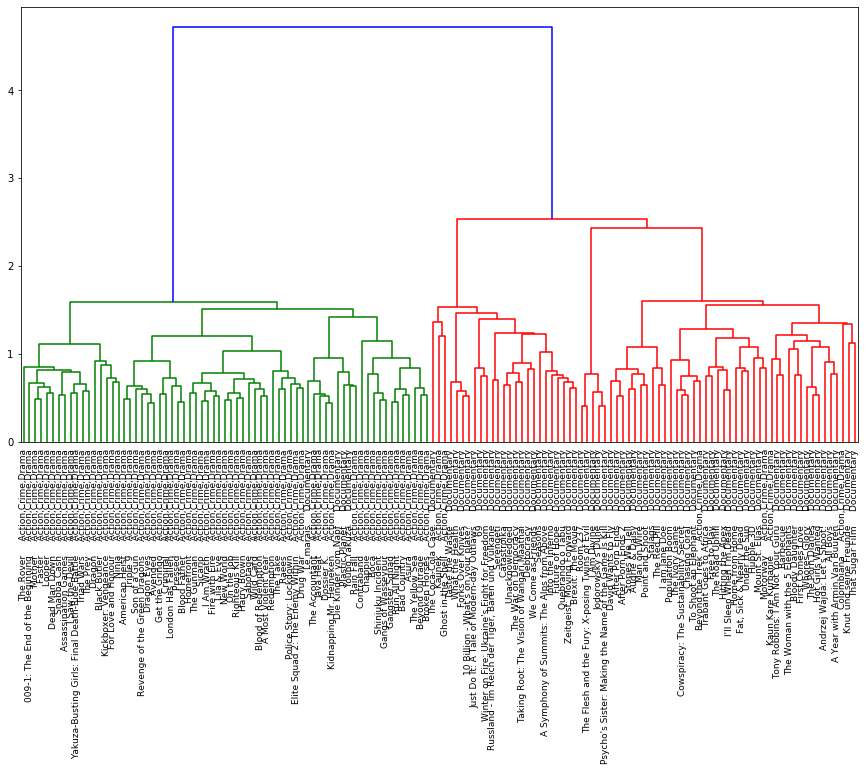

In [258]:
lmatrix = linkage_matrix(tokens.shape[0], hier_model.children_, hier_model.distances_)
plt.figure(figsize=(15,8))
dendrogram(lmatrix, labels=(df_2genre['Title'].values + "     " + df_2genre['genre'].values), leaf_font_size=9);

## Wordlist

In [280]:
count_docu = wordlister('Documentary')
#print(wordlistplot(count_docu.most_common(1000)))
count_docu.most_common(40)

[('ja', 1397),
 ('mehr', 1282),
 ('immer', 1082),
 ('gibt', 977),
 ('wurde', 961),
 ('leben', 893),
 ('gut', 889),
 ('menschen', 849),
 ('mal', 789),
 ('leute', 748),
 ('geht', 720),
 ('sagte', 718),
 ('viele', 715),
 ('schon', 659),
 ('sehen', 649),
 ('einfach', 637),
 ('sagen', 625),
 ('weiß', 580),
 ('nein', 572),
 ('welt', 563),
 ('wirklich', 553),
 ('tun', 540),
 ('zwei', 538),
 ('zeit', 524),
 ('nie', 523),
 ('tag', 513),
 ('heute', 492),
 ('müssen', 483),
 ('¼', 482),
 ('warum', 481),
 ('film', 481),
 ('macht', 471),
 ('ganz', 453),
 ('gehen', 430),
 ('geld', 429),
 ('gab', 424),
 ('jahre', 424),
 ('hast', 409),
 ('wissen', 405),
 ('jahren', 401)]

In [281]:
count_action_crime_drama = wordlister('Action,Crime,Drama')
#print(wordlistplot(count_action_crime_drama.most_common(1000))) 
count_action_crime_drama.most_common(40)

[('ja', 3099),
 ('hast', 1536),
 ('nein', 1490),
 ('mal', 1382),
 ('schon', 1334),
 ('los', 1328),
 ('gut', 1322),
 ('s', 1177),
 ('hey', 929),
 ('geht', 895),
 ('mann', 879),
 ('wer', 850),
 ('komm', 836),
 ('weiß', 828),
 ('okay', 827),
 ('bitte', 767),
 ('mehr', 727),
 ('scheiße', 650),
 ('gehen', 638),
 ('immer', 636),
 ('tun', 614),
 ('warum', 599),
 ('willst', 590),
 ('geld', 576),
 ('na', 567),
 ('gibt', 560),
 ('danke', 521),
 ('leben', 517),
 ('sehen', 514),
 ('wissen', 507),
 ('sagen', 484),
 ('müssen', 481),
 ('raus', 478),
 ('kommt', 466),
 ('kommen', 465),
 ('klar', 463),
 ('ganz', 457),
 ('zwei', 455),
 ('lass', 450),
 ('lassen', 447)]

In [195]:
for title in df_2genre.Title:
    print(title)

Kaun Kare Kurbanie
Le marais
Young Yakuza
The War on Democracy
For Love and Honour
Righteous Kill
Man on Wire
Triad Wars
Knut und seine Freunde
Taking Root: The Vision of Wangari Maathai
The Porn Diaries
69
Stalags
Shinjuku Incident
Ninja
Rain Fall
Mother
Dossier K.
Harry Brown
Plastic Planet
The Coca-Cola Case
Home from Home
Andrzej Wajda: Let's Shoot!
The Woman with the 5 Elephants
Mount St. Elias
To Shoot an Elephant
All Boys
Fat, Sick & Nearly Dead
The Yellow Sea
Snabba Cash
Faster
Hubble 3D
Elite Squad 2: The Enemy Within
Kajinek
I Saw the Devil
David Wants to Fly
Yakuza-Busting Girls: Final Death-Ride Battle
Future of Hope
Boca
Taste the Waste
Whores' Glory
Assassination Games
Forks Over Knives
Colombiana
Pressed
Dragon
The Prey
Russland - Im Reich der Tiger, Bären und Vulkane
Zeitgeist: Moving Forward
Serengeti
Trabant Goes to Africa
Debtocracy
The Road Uphill
Just Do It: A Tale of Modern-day Outlaws
Quebrando o Tabu
Die Kinder vom Napf
Looper
After Porn Ends
Contraband
Get the 

In [277]:
def wordlistersingle(title):
    singletitle = df.loc[(df['Title'] == title)]
    idx = df.index[df['Title'] == title]
    
    single_tokens = re.findall("\w+", singletitle.at[idx[0],'text'].lower())
    tokens_without_stopwords =[]
    for word in single_tokens:
        if word not in stop_words:
            tokens_without_stopwords.append(word)
    return Counter(tokens_without_stopwords), singletitle.at[idx[0],'text'], singletitle


count_singletitle, text_singletitle, df_singletitle = wordlistersingle('Plastic Planet')
#Ghost in the Shell
#Le marais
count_singletitle.most_common(40)

[('plastik', 65),
 ('ja', 32),
 ('immer', 16),
 ('gibt', 16),
 ('wissen', 16),
 ('nein', 15),
 ('bisphenol', 14),
 ('a', 14),
 ('mehr', 13),
 ('müssen', 13),
 ('sicher', 12),
 ('heute', 11),
 ('wasser', 11),
 ('studien', 11),
 ('natürlich', 10),
 ('zukunft', 10),
 ('wäre', 10),
 ('industrie', 10),
 ('gut', 10),
 ('sagen', 10),
 ('sehen', 10),
 ('material', 9),
 ('denke', 9),
 ('wurde', 9),
 ('großvater', 8),
 ('beispiel', 8),
 ('ganz', 8),
 ('frage', 8),
 ('vielleicht', 8),
 ('leben', 8),
 ('mal', 8),
 ('schon', 8),
 ('produkte', 7),
 ('kunststoffen', 7),
 ('einfach', 7),
 ('viele', 7),
 ('chemikalien', 7),
 ('weiß', 7),
 ('absolut', 7),
 ('enthält', 7)]

In [278]:
df_singletitle

,Unnamed: 0,filename,text,IMDB_ID,genre,year,production_region,corpus,duration,directors,...,imdbRating,imdbVotes,Type,DVD,BoxOffice,Production,Website,Response,labelcolor2var,labelcolor
462,462,4167962.xml,"Wunderbare Produkte , ein wunderbares Material...",tt1292648,Documentary,2009.0,"English, German, Italian, Dutch, French, Japanese",untokenisiert,95.0,nm1923741,...,7.3,"1,152",movie,12 Apr 2011,"$1,598.00",First Run Features,http://theplasticplanet.org/,True,red,red


In [279]:
text_singletitle

'Wunderbare Produkte , ein wunderbares Material ! Wenn ich an meine Kindheit denke , denke ich an Plastik . Das hängt natürlich mit meinem Großvater zusammen . Diese Graphik hat mein Großvater erstellt , sie zeigt das Produktionswachstum . Ein Produktionsvolumen von fünf Millionen Tonnen pro Jahr war für meinen Großvater der Beweis , dass Plastik eine große Zukunft hat . Dieses Wachstum ist kontinuierlich gestiegen . In Europa werden heute etwa 60 Millionen Tonnen Plastik produziert . 60 Millionen Tonnen allein in Europa ? - Ja , das sind 25 % der Weltproduktion . Das ist ein Hochdruck-Wasserleitungsrohr . Wäre es aus Beton , Metall oder Stahl , wäre es um vieles schwerer . Diese Flasche hier ist auch aus leichtem Kunststoff . Wäre sie aus Glas , wäre sie viel schwerer und ihr Transport würde viel mehr Energie verbrauchen . Wenn Sie sie fallen lassen , zerbricht sie nicht . Plastik nützt uns also in so vielen Bereichen unseres täglichen Lebens . Glas wäre ein Horror , es wäre viel schw

## Als Action, Crime, Drama eingeordnet:
##### Le Marais: 
Dokumentation zeigt das alltägliche leben in Le Marais, die Dokumentation besteht hauptsächlich aus Dialogen mit den Leuten dort -> alltagssprache; häufigsten Wörter stimmen mehr mit Action, Crime Drama überein
##### Die Kinder vom Napf:
Alltagssprache, einfache Wörter, Dialoge mit Kindern -> enthält nicht die typische sachliche Sprache der meisten Dokumentationen
##### Plastic Planet 
Trotz fachlichem Jargon, viele Interviews und Dialoge in alltagssprache, Präsens, Perfekt und Indikativ, wenig Konjunktiv und passiv oder Präteritum. Wenig Erzähleranteile, wirkt mehr wie eine Reportage in der der verantwortliche Journalist subjektiv und emotional das Geschehen beschreibt.
##### Young Yakuza 
Viel "Dialog" und nachgespielte Szenen, raue alltagssprache, Kraftausdrücke, etc.  -> Die Sprache passt gut in das Action, Crime, Drama Milieu

## Als Documentary eingeordnet:
##### Kajinek 
Textdaten fehlerhaft, enthalten nicht die Untertitel sondern eine Plotbeschreibung
##### Ghost in a Shell:
Nur die Dialoge sind untertitelt, nicht aber die "Erzählstimme" -> Extrem kurz, sachliche, fast schon militärische Sprache
##### Beyond the Track
Viele spezifische "Fachbegriffe" sci-fi, neben Alltagsdialogen viel "sachliche" Sprache und Präteritum, vgl. Bericht
##### Motorway 
viele asiatische Namen für Automobil und Motorrad spezifische Begriffe. Keine Kraftausdrücke oder raue Sprache
##### Kaun Kare Kurbanie
auffallend häufig passive oder konjunktive Sprache und Präteritum. Ebenso wenig Perfekt, wie es in der heutigen Alltagssprache gängig ist, bsp. " Wir wünschen , dass es einen tapferen Mann gab , der gut an Herzen wäre "
##### Colombiana
Untertiteltext enthält nur eine Szene aus dem Film -> sehr kurz


## Zusammenfassung
Die Wortformen, die die alltagssprache von der sachlichen Unterscheiden scheinen ein ausschlaggebender Faktor zu sein für die "falsch" eingeordneten Instanzen. Aber auch typische Begriffe der Alltagssprache haben einen großen Anteil, z.B. "okay", "danke", aber auch Kurzformen, wie "geht's" treten überwiegend im Action, Crime, Drama Cluster auf